> # Transfer learning #

Generally training huge DNN from the beginning is not a good idea. Search a neural network that solved similar problem, and reuse the lower layer of it. It is transfer learning. This increases speed of learning and reduces needed train data.

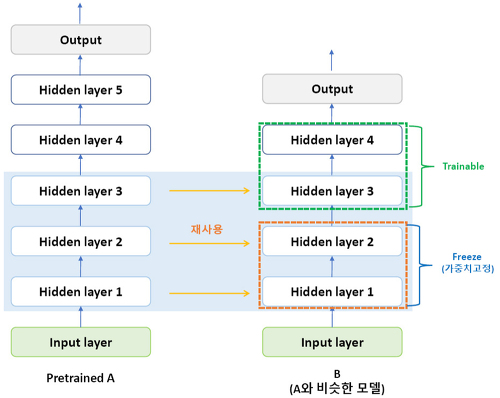

Then we have to output layer of origin model. And high layer of origin model is less useful lower layer.

First freeze all reuse lauers. And train model and evaluate performance. Then Clear freeze of one or two top hidden layers and check the performance by controling weights. As more train data we have, we can clear more layers' freeze. It is good to reduce learning rate. It is helpful for tuning weight minutely.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import warnings ; warnings.filterwarnings("ignore")

For example, we have to do binary classification which classificates shirt(positive) and sandal(negative). And we have a model A that learned a MNIST dataset well. Then we can use model A in making model B(binary classification model).

Let's use all layers except output layer.

In [2]:
model_A = keras.models.load_model("model_A.h5")
model_B = keras.models.Sequential(model_A.layers[:-1])
model_B.add(keras.layers.Dense(1, activation='sigmoid'))

Model A and B share some layers. So when we train model B, model A is affected. So we make clone of model A before reuse layers.

In [3]:
model_A_clone = keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())

We are ready for learning. But since new ouput layer is set randomly, it will make big error. So big gradient may ruin reused weights. One way to avoid this phenomenon is to freeze resued layers in first some epochs. New layer need some time to learn.

In [4]:
fasion_data = keras.datasets.fashion_mnist
(X_train, y_train), (X_test, y_test) = fasion_data.load_data()

In [8]:
## shirt ##
X_train_0 = X_train[y_train == 6]
X_test_0 = X_test[y_test == 6]
y_train_0 = (y_train[y_train == 6] == 5).astype(np.int)
y_test_0 = (y_test[y_test == 6] == 5).astype(np.int)

## sandal ##
X_train_1 = X_train[y_train == 5]
X_test_1 = X_test[y_test == 5]
y_train_1 = (y_train[y_train == 5] == 5).astype(np.int)
y_test_1 = (y_test[y_test == 5] == 5).astype(np.int)

In [9]:
a = np.arange(6000)
np.random.shuffle(a)

X_train = np.concatenate((X_train_0, X_train_1), axis=0)
y_train = np.concatenate((y_train_0, y_train_1), axis=0)

X_train = X_train[a]
y_train = y_train[a]

In [10]:
a = np.arange(1000)
np.random.shuffle(a)

X_test = np.concatenate((X_test_0, X_test_1), axis=0)
y_test = np.concatenate((y_test_0, y_test_1), axis=0)

X_test = X_test[a]
y_test = y_test[a]

In [11]:
X_train_scd, X_valid = (X_train[1000:] / 255.0) , (X_train[:1000] / 255.0)
y_train_scd, y_valid = y_train[1000:] , y_train[:1000]
X_test_scd = X_test / 255.0

In [12]:
for layer in model_B.layers[:-1]:
    layer.trainable = False
    
model_B.compile(loss="binary_crossentropy", optimizer='sgd', metrics=["accuracy"])

We can train model in some epochs. Then clear the freeze and continue train. Generally It is good to reduce learning rate.

In [13]:
history = model_B.fit(X_train_scd, y_train_scd, epochs=4, validation_data=(X_valid, y_valid))

for layer in model_B.layers[:-1]:
    layer.trainable = True
    
optimizer = keras.optimizers.SGD(lr=1e-4)
model_B.compile(loss="binary_crossentropy", optimizer='sgd', metrics=["accuracy"])
history =model_B.fit(X_train_scd, y_train_scd, epochs=26, validation_data=(X_valid, y_valid))

Epoch 1/4
157/157 [==============================] - 0s 2ms/step - loss: 0.1346 - accuracy: 0.9600 - val_loss: 0.0424 - val_accuracy: 0.9930
Epoch 2/4
157/157 [==============================] - 0s 1ms/step - loss: 0.0279 - accuracy: 0.9966 - val_loss: 0.0239 - val_accuracy: 0.9950
Epoch 3/4
157/157 [==============================] - 0s 1ms/step - loss: 0.0175 - accuracy: 0.9980 - val_loss: 0.0172 - val_accuracy: 0.9950
Epoch 4/4
157/157 [==============================] - 0s 1ms/step - loss: 0.0131 - accuracy: 0.9982 - val_loss: 0.0138 - val_accuracy: 0.9960
Epoch 1/26
157/157 [==============================] - 1s 3ms/step - loss: 0.2838 - accuracy: 0.9360 - val_loss: 0.1077 - val_accuracy: 0.9960
Epoch 2/26
157/157 [==============================] - 0s 2ms/step - loss: 0.0991 - accuracy: 0.9994 - val_loss: 0.0680 - val_accuracy: 0.9980
Epoch 3/26
157/157 [==============================] - 0s 2ms/step - loss: 0.0554 - accuracy: 1.0000 - val_loss: 0.0448 - val_accuracy: 0.9990
Epoch 4/26

In [14]:
model_B.evaluate(X_test_scd, y_test)

32/32 [==============================] - 0s 2ms/step - loss: 0.0030 - accuracy: 1.0000


[0.00304446485824883, 1.0]

It has 100% accuracy! Is it really reliable? We have to think about it.

- ### Unsupervised Pretraining ###

Suppose that we have a complex problem and there are not sufficient labeled train data. And we can't find model which learned about similar project. Then we can use unsupervised pretraining. Collecting unlabeled train samples is cheap but adding label is expensive. If we can get unlabeled train data, we can make unsupervised model like autoencoder, GAN. Then we can use lower layer of the model and add proper output layer. Finally tune final network by supervised learning.

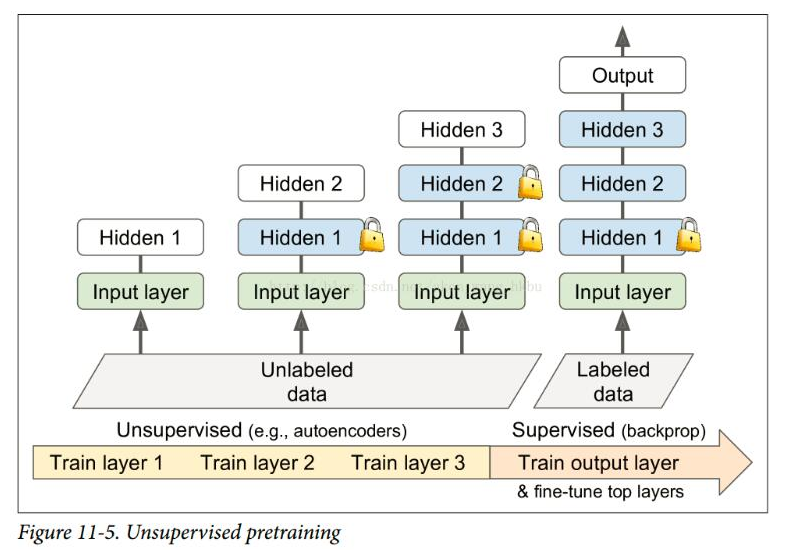

This image shows greedy layer-wise pretraining. 1.Train a unsupervised model which has one layer. Generally use RBM. 2.Freeze the layer and add a layer then train again. 3.Repeat until all layers trained. These days we use more simple method. Train all unsupervised model at once and use autouncoder or GAN instead of RBM.

The last method is to train first neural network in sub-work that gain or generate labeled train data. And reuse lower layers of the neural network for main work.

For exmaple, we want to make a face recognizing system. But there are not enough personal images. Collecting hundereds a person's images is so difficult. But we can randomly collect many person's images in Internet and train a neural network that recognizes whether two images are from same person or not.

In NLP application, we can download copus that is made up of millions text documents. And automatically generate labeled data. For example, we can train a model that predicts a blank word in a sentence. If we make a model that has good performance, we can use some lower layers of the model for main project.